In [3]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV

sns.set(style="whitegrid", palette="pastel")

In [4]:
# Load the dataset

url = "https://raw.githubusercontent.com/GK-Saravanan/copd/main/dataset_copd.csv"

# Read the CSV from GitHub raw URL
df = pd.read_csv(url)


In [5]:
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
   Patient_ID  Age  Gender  Smoking_Status Asthma_Diagnosis  \
0           1   26  Female      Non-Smoker              Yes   
1           2   52  Female       Ex-Smoker               No   
2           3   56  Female       Ex-Smoker              Yes   
3           4   55    Male  Current Smoker              Yes   
4           5   43  Female  Current Smoker               No   

              Medication  Peak_Flow  
0                Inhaler        175  
1          Not Available        156  
2                Inhaler        236  
3  Controller Medication        378  
4          Not Available        159  


In [6]:
print("Dataset info:")
df.info()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Patient_ID        300 non-null    int64 
 1   Age               300 non-null    int64 
 2   Gender            300 non-null    object
 3   Smoking_Status    300 non-null    object
 4   Asthma_Diagnosis  300 non-null    object
 5   Medication        300 non-null    object
 6   Peak_Flow         300 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 16.5+ KB


In [7]:
# Descriptive Statistics
print("Descriptive Statistics:")
df.describe().T

Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
Patient_ID,300.0,150.500000,86.746758,1.0,75.75,150.5,225.25,300.0
Age,300.0,39.666667,14.059675,18.0,27.00,39.0,51.00,65.0
Peak_Flow,300.0,278.943333,72.861027,150.0,216.50,279.0,340.25,400.0


In [8]:
# Preprocessing & Feature Engineering (after split)

# Map fixed categorical variables
gender_map = {'Male': 0, 'Female': 1, 'Other': 2}
df['Gender_Code'] = df['Gender'].map(gender_map)
smoke_map = {'Non-Smoker': 0, 'Ex-Smoker': 1, 'Current Smoker': 2}
df['Smoking_Code'] = df['Smoking_Status'].map(smoke_map)
asthma_map = {'No': 0, 'Yes': 1}
df['Asthma_Code'] = df['Asthma_Diagnosis'].map(asthma_map)


In [9]:
# Define X and y with encoded columns
X = df[['Age', 'Peak_Flow', 'Gender_Code', 'Smoking_Code', 'Medication']]
y = df['Asthma_Code']

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nTrain set shape:", X_train.shape, "Test set shape:", X_test.shape)
print("Train set class distribution:\n", y_train.value_counts())
print("Test set class distribution:\n", y_test.value_counts())


Train set shape: (240, 5) Test set shape: (60, 5)
Train set class distribution:
 Asthma_Code
1    126
0    114
Name: count, dtype: int64
Test set class distribution:
 Asthma_Code
1    31
0    29
Name: count, dtype: int64


In [11]:
# Handle missing values with training set stats
mean_pf_train = X_train['Peak_Flow'].mean()
X_train['Peak_Flow'] = X_train['Peak_Flow'].fillna(mean_pf_train)
X_test['Peak_Flow'] = X_test['Peak_Flow'].fillna(mean_pf_train)

mode_med_train = X_train['Medication'][X_train['Medication'] != 'Not Available'].mode()[0]
X_train['Medication'] = X_train['Medication'].replace('Not Available', mode_med_train)
X_test['Medication'] = X_test['Medication'].replace('Not Available', mode_med_train)

In [12]:

# Create new feature: Age-Peak_Flow Interaction
mean_age = X_train['Age'].mean()
std_age = X_train['Age'].std()
mean_pf = X_train['Peak_Flow'].mean()
std_pf = X_train['Peak_Flow'].std()
X_train['Age_PF_Interaction'] = ((X_train['Age'] - mean_age) / std_age) * ((X_train['Peak_Flow'] - mean_pf) / std_pf)
X_test['Age_PF_Interaction'] = ((X_test['Age'] - mean_age) / std_age) * ((X_test['Peak_Flow'] - mean_pf) / std_pf)

In [13]:
# Create PF_Ratio with training set mean
mean_pf_ratio = X_train['Peak_Flow'].mean()
X_train['PF_Ratio'] = X_train['Peak_Flow'] / mean_pf_ratio
X_test['PF_Ratio'] = X_test['Peak_Flow'] / mean_pf_ratio

In [14]:
# Map Medication after handling 'Not Available'
med_map = {m: i for i, m in enumerate(X_train['Medication'].unique())}
X_train['Medication_Code'] = X_train['Medication'].map(med_map)
X_test['Medication_Code'] = X_test['Medication'].map(med_map)

In [15]:
# Remove outliers from training set only
Q1_age = X_train['Age'].quantile(0.25)
Q3_age = X_train['Age'].quantile(0.75)
IQR_age = Q3_age - Q1_age
lower_age = Q1_age - 1.5 * IQR_age
upper_age = Q3_age + 1.5 * IQR_age
Q1_pf = X_train['Peak_Flow'].quantile(0.25)
Q3_pf = X_train['Peak_Flow'].quantile(0.75)
IQR_pf = Q3_pf - Q1_pf
lower_pf = Q1_pf - 1.5 * IQR_pf
upper_pf = Q3_pf + 1.5 * IQR_pf
mask = (X_train['Age'].between(lower_age, upper_age)) & (X_train['Peak_Flow'].between(lower_pf, upper_pf))
X_train = X_train[mask]
y_train = y_train[mask]

In [16]:
# Select features
features = ['Age', 'Peak_Flow', 'PF_Ratio', 'Gender_Code', 'Smoking_Code', 'Medication_Code', 'Age_PF_Interaction']
X_train = X_train[features]
X_test = X_test[features]

In [17]:
# Scale the features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [18]:
# Exploratory Data Analysis (EDA)

# Temporary feature for EDA
mean_age = df['Age'].mean()
std_age = df['Age'].std()
mean_pf = df['Peak_Flow'].mean()
std_pf = df['Peak_Flow'].std()
df['Age_PF_Interaction'] = ((df['Age'] - mean_age) / std_age) * ((df['Peak_Flow'] - mean_pf) / std_pf)
df['PF_Ratio'] = df['Peak_Flow'] / df['Peak_Flow'].mean()
df['Age_Group'] = df['Age'].apply(lambda x: 'Child' if x < 18 else 'Adult' if x < 40 else 'Senior')

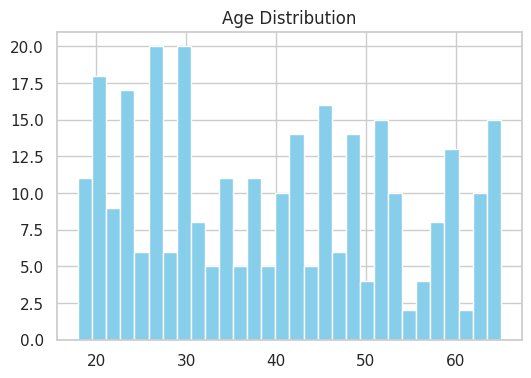

In [19]:
# 1. Age Distribution
plt.figure(figsize=(6, 4))
plt.hist(df['Age'], bins=30, color='skyblue')
plt.title("Age Distribution")
plt.show()

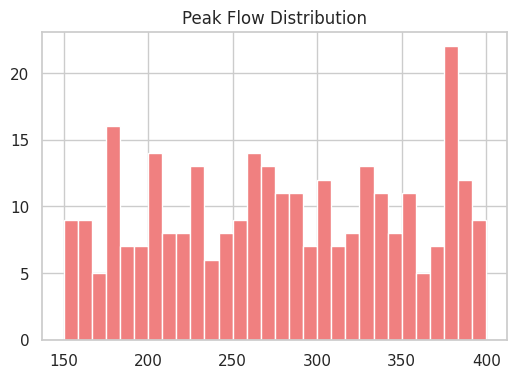

In [20]:
# 2. Peak Flow Distribution
plt.figure(figsize=(6, 4))
plt.hist(df['Peak_Flow'], bins=30, color='lightcoral')
plt.title("Peak Flow Distribution")
plt.show()

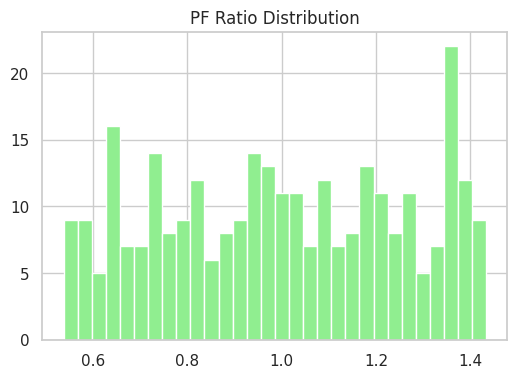

In [21]:
# 3. PF Ratio Distribution
plt.figure(figsize=(6, 4))
plt.hist(df['PF_Ratio'], bins=30, color='lightgreen')
plt.title("PF Ratio Distribution")
plt.show()

/tmp/ipython-input-2906018851.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=df, palette='pastel', label='Gender')
/tmp/ipython-input-2906018851.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Smoking_Status', data=df, palette='pastel', label='Smoking Status')
/tmp/ipython-input-2906018851.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Medication', data=df, palette='pastel', label='Medication')


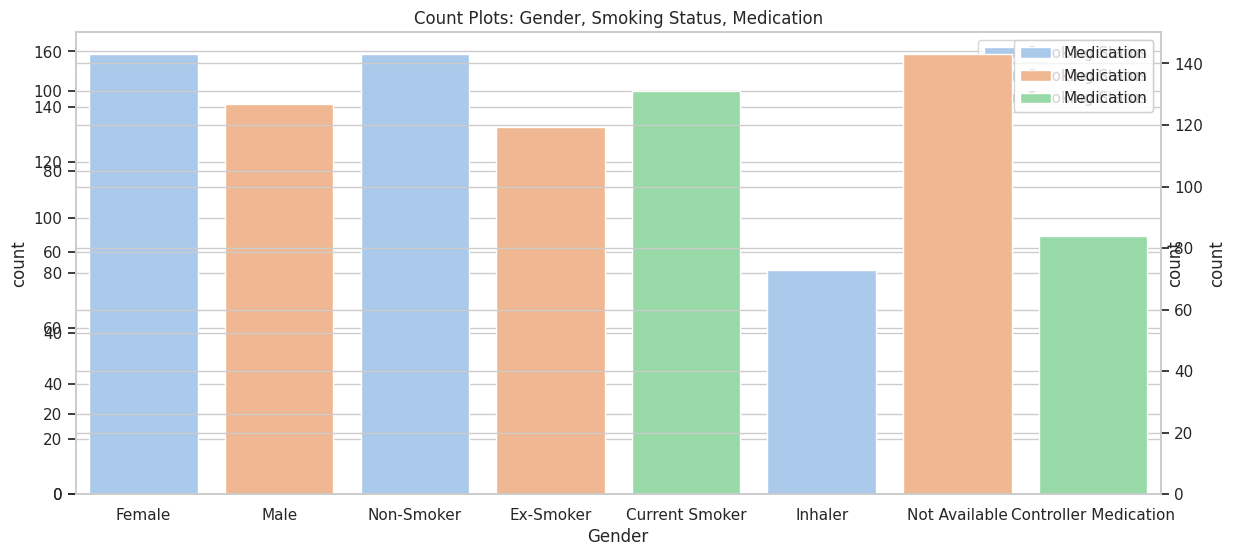

In [22]:
# 4. Combined Count Plots (Gender, Smoking Status, Medication)
plt.figure(figsize=(14, 6))
plt.title("Count Plots: Gender, Smoking Status, Medication")
sns.countplot(x='Gender', data=df, palette='pastel', label='Gender')
plt.legend()
plt.twinx()
sns.countplot(x='Smoking_Status', data=df, palette='pastel', label='Smoking Status')
plt.legend()
plt.twinx()
sns.countplot(x='Medication', data=df, palette='pastel', label='Medication')
plt.legend()
plt.xticks(rotation=45)
plt.show()

/tmp/ipython-input-1455236246.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Smoking_Status', y='Peak_Flow', data=df, palette='pastel')
/tmp/ipython-input-1455236246.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Age_Group', y='Peak_Flow', data=df, palette='pastel')


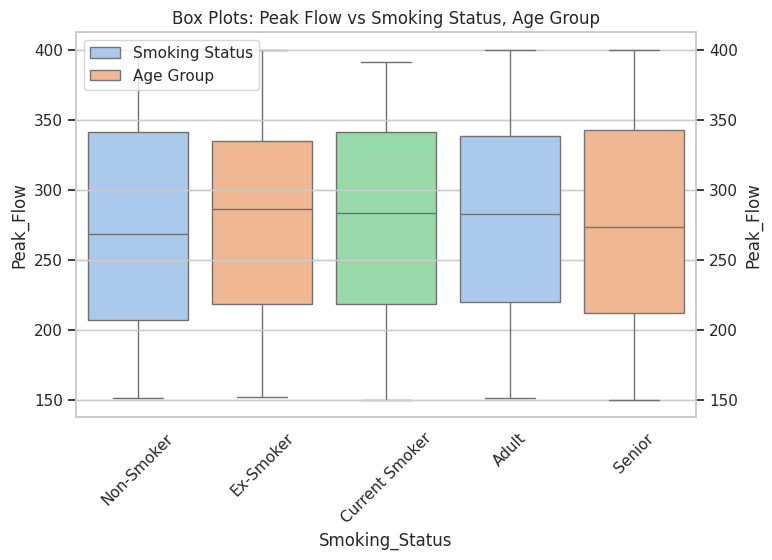

In [23]:
# 5. Combined Box Plots (Peak Flow vs Smoking Status, Age Group)
plt.figure(figsize=(8, 5))
plt.title("Box Plots: Peak Flow vs Smoking Status, Age Group")
sns.boxplot(x='Smoking_Status', y='Peak_Flow', data=df, palette='pastel')
plt.xticks(rotation=45)
plt.twinx()
sns.boxplot(x='Age_Group', y='Peak_Flow', data=df, palette='pastel')
plt.legend(['Smoking Status', 'Age Group'])
plt.show()

/tmp/ipython-input-72205967.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Asthma_Diagnosis', y='PF_Ratio', data=df, palette='pastel')


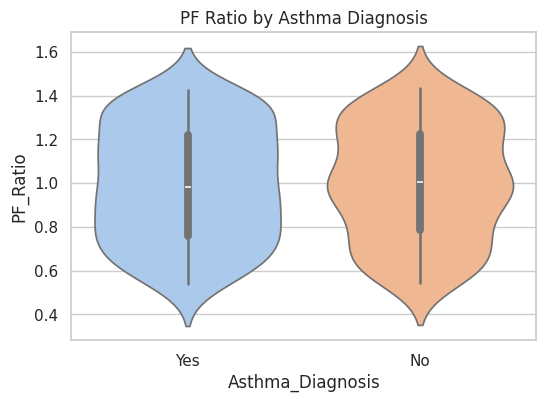

In [24]:
# 6. PF Ratio by Asthma Diagnosis
plt.figure(figsize=(6, 4))
sns.violinplot(x='Asthma_Diagnosis', y='PF_Ratio', data=df, palette='pastel')
plt.title("PF Ratio by Asthma Diagnosis")
plt.show()

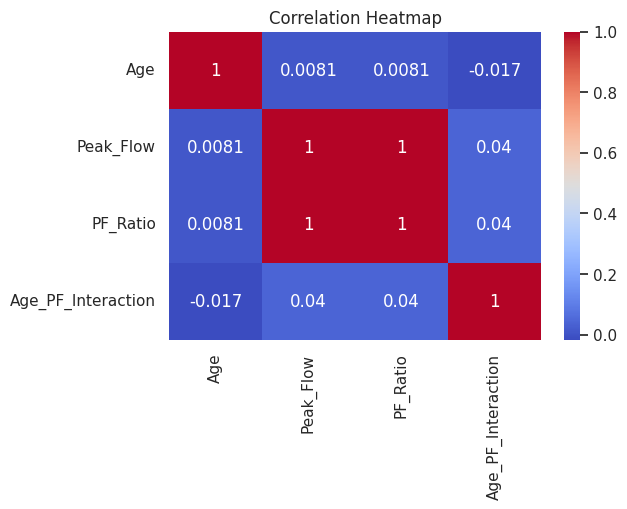

In [25]:
# 7. Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df[['Age', 'Peak_Flow', 'PF_Ratio', 'Age_PF_Interaction']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

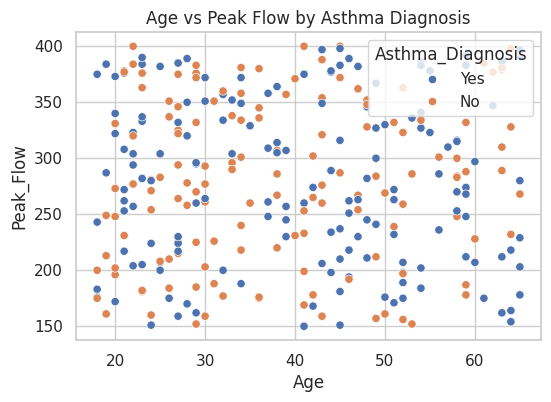

In [26]:
# 8. Age vs Peak Flow by Asthma Diagnosis
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Age', y='Peak_Flow', hue='Asthma_Diagnosis', data=df, palette='deep')
plt.title("Age vs Peak Flow by Asthma Diagnosis")
plt.show()

/tmp/ipython-input-2215338676.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_counts = df.groupby([age_bins, 'Asthma_Diagnosis']).size().unstack(fill_value=0)


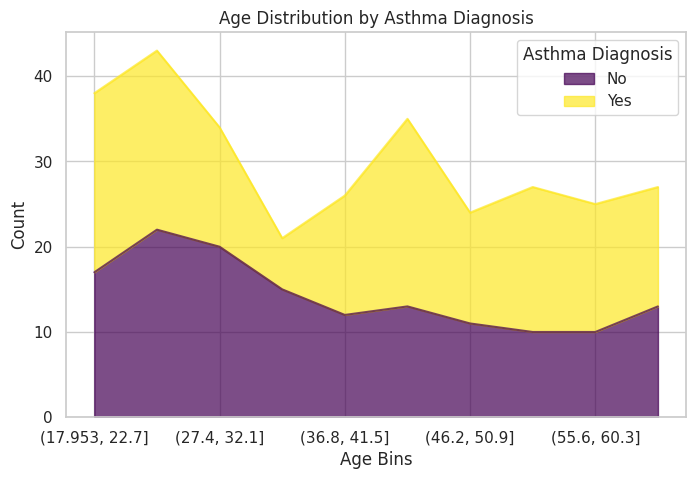

In [27]:
# 9. Age Distribution by Asthma Diagnosis
plt.figure(figsize=(8, 5))
age_bins = pd.cut(df['Age'], bins=10)
age_counts = df.groupby([age_bins, 'Asthma_Diagnosis']).size().unstack(fill_value=0)
age_counts.plot(kind='area', stacked=True, ax=plt.gca(), alpha=0.7, colormap='viridis')
plt.title("Age Distribution by Asthma Diagnosis")
plt.xlabel("Age Bins")
plt.ylabel("Count")
plt.legend(title="Asthma Diagnosis")
plt.show()

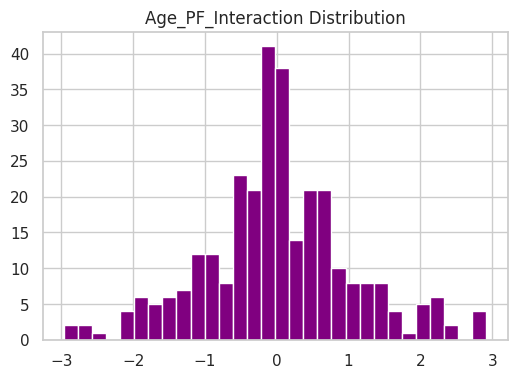

In [28]:
# 10. Age_PF_Interaction Distribution
plt.figure(figsize=(6, 4))
plt.hist(df['Age_PF_Interaction'], bins=30, color='purple')
plt.title("Age_PF_Interaction Distribution")
plt.show()

/tmp/ipython-input-4036963354.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Gender', y='PF_Ratio', data=df, palette='pastel')


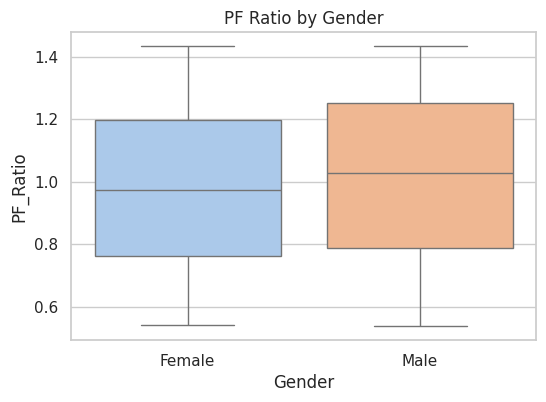

In [29]:
# 11. PF_Ratio by Gender
plt.figure(figsize=(6, 4))
sns.boxplot(x='Gender', y='PF_Ratio', data=df, palette='pastel')
plt.title("PF Ratio by Gender")
plt.show()

/tmp/ipython-input-3797678680.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Medication', y='Peak_Flow', data=df, palette='pastel')


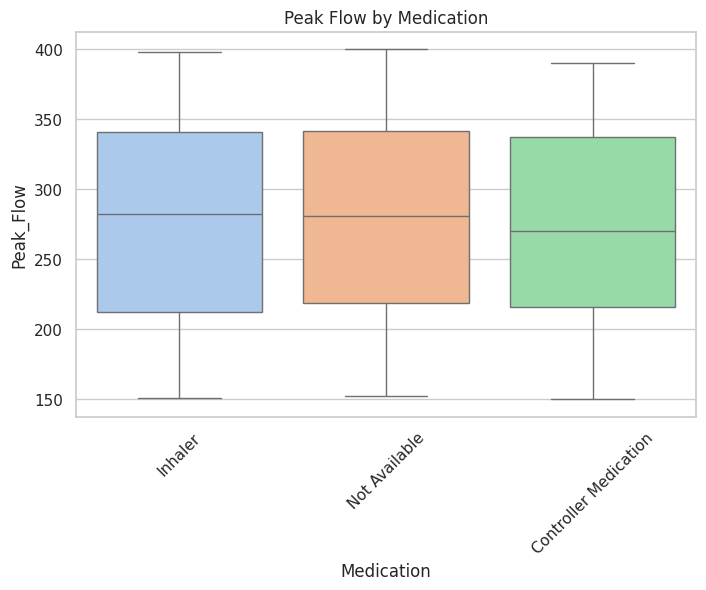

In [30]:
# 12. Peak Flow by Medication
plt.figure(figsize=(8, 5))
sns.boxplot(x='Medication', y='Peak_Flow', data=df, palette='pastel')
plt.title("Peak Flow by Medication")
plt.xticks(rotation=45)
plt.show()

In [31]:
# Clean up temporary columns
df.drop(['Age_PF_Interaction', 'PF_Ratio', 'Age_Group'], axis=1, inplace=True)

In [32]:
# Fine-Tuned Model Training with Cross-Validation

# Random Forest with GridSearchCV
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5)
rf_grid.fit(X_train_s, y_train)
rf = rf_grid.best_estimator_
print("Best RF Params:", rf_grid.best_params_)

Best RF Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [33]:
# SVM with GridSearchCV
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto']}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid, cv=5)
svm_grid.fit(X_train_s, y_train)
svm = svm_grid.best_estimator_
print("Best SVM Params:", svm_grid.best_params_)

Best SVM Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [34]:
# XGBoost with Manual Tuning
xgb = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=150, use_label_encoder=False,
                    eval_metric='logloss', random_state=42)
xgb.fit(X_train_s, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:45:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

In [35]:
# Gradient Boosting with Manual Tuning
gb = GradientBoostingClassifier(learning_rate=0.05, n_estimators=200, max_depth=4, subsample=0.8,
                               random_state=42)
gb.fit(X_train_s, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, n_estimators=200,
                           random_state=42, subsample=0.8)

In [36]:
# Evaluate and print results
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf.predict(X_test_s)))
print("RF ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test_s)[:, 1]))
cv_scores_rf = cross_val_score(rf, X_train_s, y_train, cv=5, scoring='roc_auc')
print("RF CV ROC AUC (mean ± std):", cv_scores_rf.mean(), "±", cv_scores_rf.std())


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63        29
           1       0.66      0.68      0.67        31

    accuracy                           0.65        60
   macro avg       0.65      0.65      0.65        60
weighted avg       0.65      0.65      0.65        60

RF ROC AUC: 0.7174638487208009
RF CV ROC AUC (mean ± std): 0.6977768318637884 ± 0.05034124094203367


In [37]:
print("\nSVM Classification Report:")
print(classification_report(y_test, svm.predict(X_test_s)))
print("SVM ROC AUC:", roc_auc_score(y_test, svm.predict_proba(X_test_s)[:, 1]))
cv_scores_svm = cross_val_score(svm, X_train_s, y_train, cv=5, scoring='roc_auc')
print("SVM CV ROC AUC (mean ± std):", cv_scores_svm.mean(), "±", cv_scores_svm.std())


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        29
           1       1.00      0.48      0.65        31

    accuracy                           0.73        60
   macro avg       0.82      0.74      0.72        60
weighted avg       0.83      0.73      0.72        60

SVM ROC AUC: 0.7552836484983315
SVM CV ROC AUC (mean ± std): 0.7305618729096991 ± 0.03764100398106667


In [38]:
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb.predict(X_test_s)))
print("XGBoost ROC AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test_s)[:, 1]))
cv_scores_xgb = cross_val_score(xgb, X_train_s, y_train, cv=5, scoring='roc_auc')
print("XGBoost CV ROC AUC (mean ± std):", cv_scores_xgb.mean(), "±", cv_scores_xgb.std())


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.59      0.60        29
           1       0.62      0.65      0.63        31

    accuracy                           0.62        60
   macro avg       0.62      0.62      0.62        60
weighted avg       0.62      0.62      0.62        60

XGBoost ROC AUC: 0.7230255839822024


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:45:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:45:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:45:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:45:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost CV ROC AUC (mean ± std): 0.7057695348130131 ± 0.03337854943669533


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:45:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [39]:
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, gb.predict(X_test_s)))
print("Gradient Boosting ROC AUC:", roc_auc_score(y_test, gb.predict_proba(X_test_s)[:, 1]))
cv_scores_gb = cross_val_score(gb, X_train_s, y_train, cv=5, scoring='roc_auc')
print("Gradient Boosting CV ROC AUC (mean ± std):", cv_scores_gb.mean(), "±", cv_scores_gb.std())


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67        29
           1       0.69      0.65      0.67        31

    accuracy                           0.67        60
   macro avg       0.67      0.67      0.67        60
weighted avg       0.67      0.67      0.67        60

Gradient Boosting ROC AUC: 0.7196885428253614
Gradient Boosting CV ROC AUC (mean ± std): 0.7096102158710854 ± 0.03933675762196061


/tmp/ipython-input-1249803227.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=acc_df, ax=ax, palette='viridis')


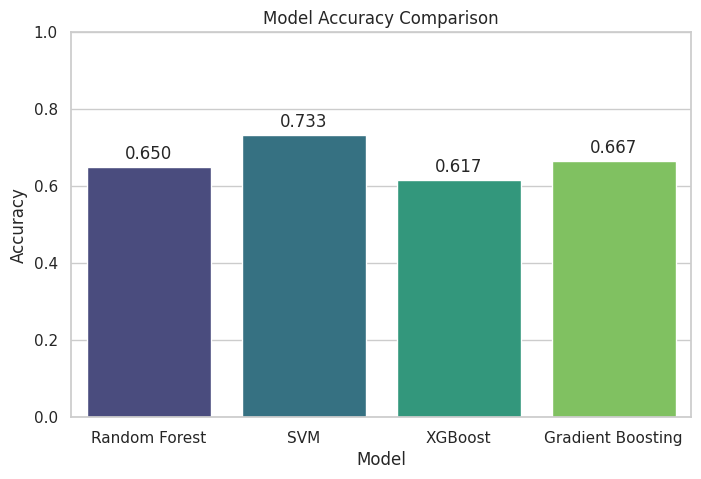

In [40]:
# Accuracy Comparison Plot
acc_df = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'XGBoost', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test, rf.predict(X_test_s)),
        accuracy_score(y_test, svm.predict(X_test_s)),
        accuracy_score(y_test, xgb.predict(X_test_s)),
        accuracy_score(y_test, gb.predict(X_test_s))
    ]
})
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=acc_df, ax=ax, palette='viridis')
ax.set_title("Model Accuracy Comparison")
ax.set_ylim(0, 1)
for i, v in enumerate(acc_df['Accuracy']):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center')
plt.show()

/tmp/ipython-input-1367263315.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, ax=ax, palette='magma')


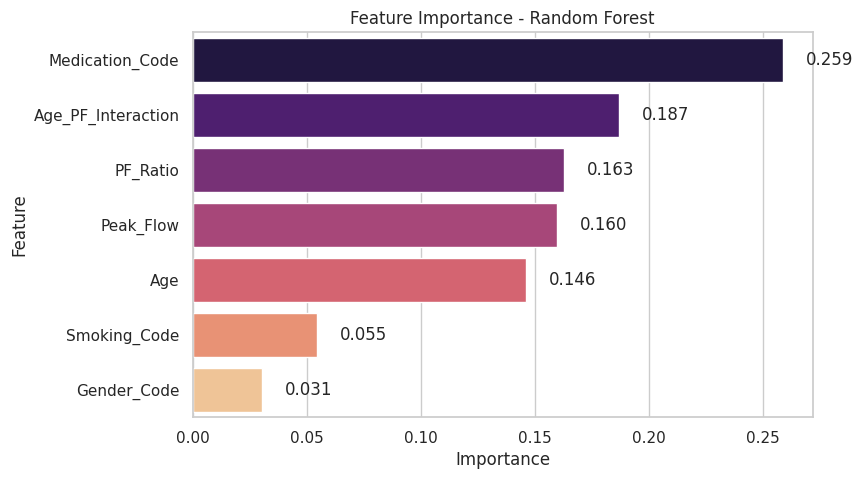

In [41]:
# Feature Importance for Random Forest
fig, ax = plt.subplots(figsize=(8, 5))
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importance_df, ax=ax, palette='magma')
ax.set_title("Feature Importance - Random Forest")
for i, v in enumerate(importance_df['Importance']):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center')
plt.show()